In [32]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.optimize import minimize
from scipy.optimize import fmin
import matplotlib.pyplot as plt
from itertools import chain

import warnings
warnings.filterwarnings("ignore")
import os
if not os.path.exists('plots/'):
    os.mkdir('plots')
if not os.path.exists('data_saved/'):
    os.mkdir('data_saved')
if not os.path.exists('data_saved/Mimization'):
    os.mkdir('data_saved/Mimization')    
    
def data_save(filename, Xdata, Ydata):
    combined_data = [ Xdata, Ydata]
    combined_data = [[row[i] for row in combined_data] for i in range(len(combined_data[0]))]
    filename_saving= ('data_saved/Mimization/'+filename+'.txt')
    with open(filename_saving, 'w+') as output_file:
        np.savetxt(output_file, combined_data,fmt='%.14e')
    output_file.close()     
    

In [33]:
# Experimental data for NaCl MIC
NaCl_initial = [0.5 ,1.0, 1.5, 2.0, 2.5] 
NaCl_M = [i*0.1 for i in NaCl_initial]
NaCl_mM = [i*100 for i in NaCl_initial]

# Combine Sattar's Data with different salt concentrations:
NaCl = [0.5 ,1.0, 1.5, 2.0, 2.5] #units 100mM
MIC_NaCl = [ 1.12, 1.25, 1.62 ,1.75, 2 ] #units µM

# Convert NaCl concentration to kappa length
def mol_to_kappa(mM):
    Molar = mM * 10**(-3)  
    kappa = 0.304/np.sqrt(Molar)*10 #Length unit in amstrong
    return 1/ kappa

kappa_range = [mol_to_kappa(mM) for mM in NaCl_mM ]


In [39]:
# Define variables 
Eps         = 8.85e-12               # Vacuum permittivity(coloum^2/Jm)         
T           = 300                    # Tempreture (kelvin)
Kb          = 1.38*1e-23             # Boltzmann Constant (J/kelvin)
Dw          = 80                     # Water dielectric constant
NA          = 6.023*1e+23            # Avagadro's number
V           = 1e27                   # Total volume in (A^3) 
ele         = 1.6e-19                # Electron Charge
lb          = ele**2*1e10/(4*np.pi*Eps*Dw*Kb*T)   # Bejurium Length in meter (A)
V           = 1e27                   # Total volume in (A^3) 
KA          = 0.578                  # Stretch Modulus (KbT/A^2)

#Melittin or LL-37 peptide parameter
A_p = 400;                           # physical area of peptide A^2
SM = 1/400;                        # number of sites per area 1/A^2
vp = 33**3;                         #% volume of peptide in bulk A^3 
apef= 400;

# Bacterial Cell (E.coli)
A = 2*6e-12*1e20   # Surface area (twice of E-coli) (m^2*1e20 = A^2)
al = 71            #lipid area
alph = 0.3;        # charged lipid percentage 
Vb = 1*1e-18*1e30; 
NA = 6.023*1e+23;           # %Avagadro's number

# Peptide parameter define 
Q = 6;      # Peptide charge for peptide LL-37
A1 = 725;  # n*alpha*f_A : total area of lipid
# f_A = .586;  # Fraction of anionic lipids
f_A = 1;  # Fraction of anionic lipids
a0 = 71;   # Surface area per lipid
b = 4.1; # Twice the persistence length of melittin (length of one monomer amino acid) 
N = 37;  # number of amino acids (LL-37)


f_A = .586;  # Fraction of anionic lipids
hydrophobic_E = -8

# f_A = 1;  # Fraction of anionic lipids
# hydrophobic_E = -10

# Minimization method 

In [40]:
# Minimization method applied

def competeE(x1):
    A1= 1/x1 # minimize w.r.t sigma_p
    delF = electrostatic_E(x1)
    delF = delF*x1
    Ent_free = (1/(V*Ct*A ))*((V*(Cp-Ct*A *(x1)-Ct))* np.log((Cp-Ct*A *(x1)-Ct)*vp)
                - V*(Cp-Ct*A *(x1)-Ct) - (V*Cp*np.log(Cp*vp)-V*Cp)) #+x1*np.log(x1/SM)
    return  delF + Ent_free    # Total Free energy per area
    
# Simplified electrostatic binding Energy
def electrostatic_E(x1):

    A1= 1/x1
    sig_net = (Q/A1) - (f_A/a0)
    phi_0 = 2* np.arcsinh((2*np.pi*lb*sig_net)/kappa)
    f_plate = (sig_net *phi_0)  -((kappa/(np.pi*lb))*(np.cosh(phi_0/2)-1))
    f_el_S = f_plate*A1
    
    sig_0 = -(f_A/a0)
    phi_00 = 2* np.arcsinh((2*np.pi*lb*sig_0)/kappa)
    f_plate_0 = (sig_0 *phi_00 ) - ((kappa/(np.pi*lb))*(np.cosh(phi_00/2)-1))
    f_el_S_0 = f_plate_0*A1
    
    lambda2 = 0.126 # lambda2 = e^2/(4*eps*r0*kT)
    r0 = 15   #radius of the peptide ([A] Angstrom)
    lambda3 = kappa*r0
    f_el_L = (2*Q**2 *lambda2)/(1+lambda3)
    
#     hydrophobic_E = -10
    return f_el_S - f_el_S_0 - f_el_L + hydrophobic_E

def free_energy(Cp, Ct, X0):
    bnds = [(0, 0.01)]
    tolerance= 1e-12
    solution = minimize(competeE,X0, tol=tolerance, method = 'SLSQP',bounds =bnds)
    x = solution.x
    x1= x[0]
    return x1


def binding_E_wB(MIC ,CB, P_LI):

    # This function return binding energy for host cell
    NA = 6.023*1e+23;           # Avagadro's number
    vp = 33**3;                 # Melittin random coil's volume
    Ap_ent = 400;               # Physical Area per peptide
    TresholdB = P_LI
    Ab = 2*6e-12*1e20           # Surface area of bacterium's membrane(twice of E-coli) (m^2*1e20 = A^2)
    alb = 71;# 
    # % Calculate Langmuir-like binding energy from one data set (MIC_Ct0 , Ct0_B) of full analysis
    MIC_Ct0 = MIC*((1e-6)*NA*(1e-27));
    wB = np.log((MIC_Ct0 - Ab/alb*TresholdB*CB)* vp*(1-Ap_ent/alb*TresholdB)/(Ap_ent/alb*TresholdB))
    return wB



# Find Binding Energy & Map to Langmuir Model

MIC: Kappa =  0.07355486768091414 Cp =  0.8431909292866255  P/L =  0.09999987285458138  W_b =  -11.166210607956408
MIC: Kappa =  0.10402229145290721 Cp =  1.208042134677329  P/L =  0.09999828406168575  W_b =  -10.806606356378948
MIC: Kappa =  0.12740076796734923 Cp =  1.5494950393146316  P/L =  0.10000870003370843  W_b =  -10.557914241554135
MIC: Kappa =  0.14710973536182828 Cp =  1.8461469463245477  P/L =  0.09999766946465632  W_b =  -10.382488508894577
MIC: Kappa =  0.16447368421052633 Cp =  2.119953457536071  P/L =  0.09999676017376162  W_b =  -10.244173302752895


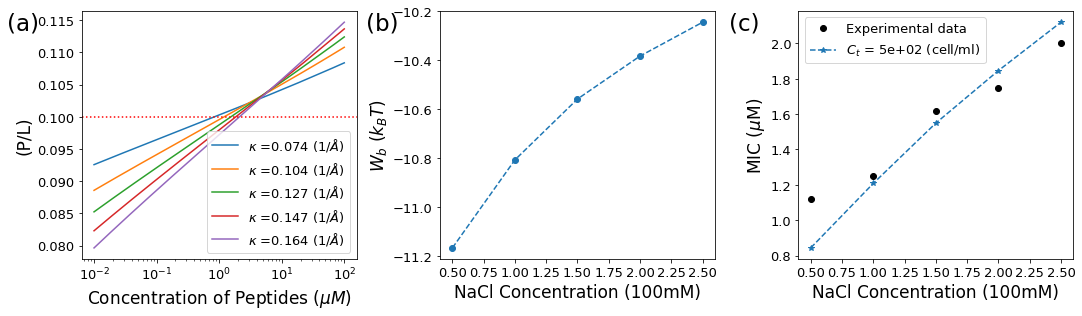

In [43]:
BE_wB   = []
MIC_save = {'kappa': [], 'Cp':[],'Ct':[], 'P/L':[],'W_b':[]}

Cp_range = np.logspace(-2,2, num=1000) #Bulk concentration range 
PL_B = 0.1
X0 = 0.001

P_L_list =[]

plt.figure(figsize=(15,4.5))#,dpi=1500)
ax1 = plt.subplot(1,3,1)
for kappa in kappa_range:
    Ct_cell = 5*10**(3)
    P_LI    = []
    for Cp_val in Cp_range:
        Cp = Cp_val*((1e-6)*NA*(1e-27));
        Ct = Ct_cell *1e-24;
        x1= free_energy(Cp, Ct, X0)
        P_LI.append(x1*a0)

    P_LI = np.asarray(P_LI)
    idx = (np.abs(P_LI - PL_B)).argmin()
    W_b = binding_E_wB(Cp_range[idx] ,Ct, P_LI[idx])
    BE_wB.append(W_b)
    print('MIC: Kappa = ',kappa ,'Cp = ',Cp_range[idx],' P/L = ',P_LI[idx], ' W_b = ',W_b)

    MIC_save['kappa'].append(kappa)
    MIC_save['Cp'].append(Cp_range[idx])
    MIC_save['Ct'].append(Ct_cell)
    MIC_save['P/L'].append(P_LI[idx])
    MIC_save['W_b'].append(W_b)

    plt.plot(Cp_range,P_LI,label=r'$\kappa$ =%1.3f $(1/{\AA})$'%kappa)
    P_L_list.append(P_LI)
plt.xscale('log')
plt.axhline(y=PL_B, color='r', linestyle=':')
plt.ylabel('(P/L)', fontsize = 17)
plt.xlabel('Concentration of Peptides ($\mu M$)', fontsize = 17)
plt.legend( fontsize = 13)    
plt.xticks(fontsize= 13)  
plt.yticks(fontsize= 13)
plt.text(-0.27,.925,"(a)",fontsize=23, transform=ax1.transAxes)
    
ax2 = plt.subplot(1,3,2)
plt.plot(NaCl_initial,BE_wB,'--o')#,color=cycle[1])
plt.xlabel('NaCl Concentration (100mM)' , fontsize = 17)
plt.ylabel('$W_b$ $(k_B T)$',fontsize = 17)
plt.text(-0.27,.925,"(b)",fontsize=23, transform=ax2.transAxes)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Langmuir model mapping
A_p = 400           #Amstrong square
v_p = 33**3         #Amstrong cube
A_B = 400           #Amstrong square (Surface area of each cells)
A_H = A_B        #Amstrong square
a_B = 71            #Amstrong square (Area of each lipids)
a_H = 74             #Angstrom square 
A_t = 12*10**8 #Ah and Ab
At = 12*10**8 #Ah and Ab

# Priminary Constant values
avo_con = 6.023*10**23 #Avogadro constant ==> 6.022 × 10^23 mol^(-1)
mu_M_unit = 10**-6*avo_con *10**-27
unit =10**-24 #(unit conversion)

def MIC_non_competitive_membrane(CB, w_B, PL_B):    

    MIC_0 = 1/v_p* A_B/a_B * PL_B /(1-  A_B/a_B * PL_B)*(np.exp(w_B))
    eq1   = (PL_B*At/a_B ) *CB*unit +  MIC_0
    Cp    = eq1/mu_M_unit
    
    return Cp

# Combine Sattar's Data with different salt concentrations:
ax3 = plt.subplot(1,3,3)

plt.plot(NaCl,MIC_NaCl,'o',label='Experimental data',color='k')

CB_range = [5*10**(i) for i in range(2,3,2)]
for j,CB in enumerate(CB_range):
    MIC_values=[]
    for i, w_B in enumerate(MIC_save['W_b']):
        MIC_values.append(MIC_non_competitive_membrane(CB,w_B,PL_B))
    plt.plot(NaCl_initial, MIC_values,'--',label=r'$C_t$ = %1.0e (cell/ml)'%(CB), marker='*')#,color=cycle[j+1])#),color='red')
    plt.xlabel('NaCl Concentration (100mM)' , fontsize = 17)
    plt.ylabel('MIC ($\mu$M)', fontsize = 17)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
plt.legend( fontsize = 13,loc='best')    
# plt.legend( fontsize = 13, bbox_to_anchor=(0.1, 0.1))    

plt.text(-0.25,.925,"(c)",fontsize=23, transform=ax3.transAxes)    
    
plt.tight_layout()
plt.savefig('plots/'+('Outer_layer_PL_01_minimization')+'.pdf',bbox_inches='tight')




# Save Data

In [45]:


for i, kappa in enumerate(kappa_range):
    filename1 = 'Cp_vs_PL_at_Kappa_%1.3f'%(kappa)
    PL_data = P_L_list[i]
    data_save(filename1,Cp_range, PL_data)


# Binding E
filename1 = 'Outer_membrane_bindingE'
data_save(filename1,NaCl_initial,BE_wB)


# MIC
filename1 = 'Outer_membrane_MIC'
data_save(filename1,NaCl_initial, MIC_values)

filename1 = 'Experimental_MIC'
data_save(filename1,NaCl_mM, MIC_NaCl)





In [16]:
# MIC_values_inner = [0.9954980544144842, 1.36644154307164, 1.6180350813354134, 1.8044606369832776, 1.9500616691099228]
# MIC_values_outer = [0.890806861723998, 1.3310550186074614,  1.646220263212142, 1.8860509715581246,  2.0755473549899413]


# MIC_values_min  = [0.8450515789396349, 1.2107143663655144,  1.5392059304904229,  1.8501641924955339,  2.1245678998608724]

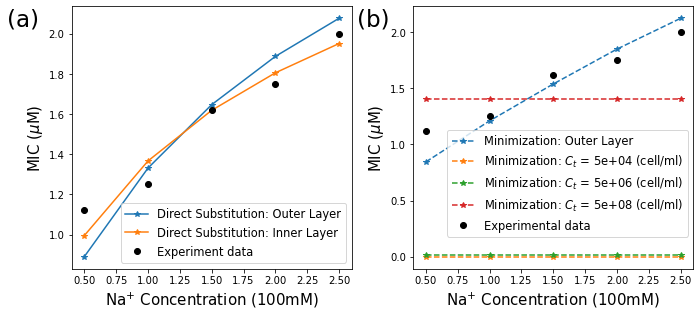

In [17]:
plt.figure(figsize=(10,4.5))

ax1 = plt.subplot(1,2,1)

plt.plot(NaCl_initial, MIC_values_outer,'-*',label='Direct Substitution: Outer Layer')
plt.plot(NaCl_initial, MIC_values_inner,'-*',label='Direct Substitution: Inner Layer')
plt.plot(NaCl_initial,MIC_NaCl,'o',label='Experiment data',color ='k')
plt.xlabel('$\mathregular{Na}^{+}$ Concentration (100mM)' , fontsize = 15)
plt.ylabel('MIC ($\mu$M)', fontsize = 15)
plt.legend(fontsize=11.5)
plt.text(-0.23,.925,"(a)",fontsize=23, transform=ax1.transAxes)



ax2 = plt.subplot(1,2,2)

plt.plot(NaCl_initial, MIC_values_min,'--*',label='Minimization: Outer Layer')
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

CB_range = [5*10**(i) for i in range(4,10,2)]
for j,CB in enumerate(CB_range):
    MIC_values=[]
    for i, w_B in enumerate(MIC_save['W_b']):
        MIC_values.append(MIC_non_competitive_membrane(CB,w_B,PL_B))
    plt.plot(NaCl_initial, MIC_values,'--*',label=r'Minimization: $C_t$ = %1.0e (cell/ml)'%(CB))#, marker='*',color='red')
    plt.xlabel('$\mathregular{Na}^{+}$ Concentration (100mM)' , fontsize = 15)
    plt.ylabel('MIC ($\mu$M)', fontsize = 15)
plt.plot(NaCl,MIC_NaCl,'o',label='Experimental data',color='k')
plt.legend( fontsize = 11.5, bbox_to_anchor=(0.1, 0.1))    


plt.text(-0.2,.925,"(b)",fontsize=23, transform=ax2.transAxes)

plt.tight_layout()
plt.savefig('plots/'+('Compare_Ex_Th')+'.pdf',bbox_inches='tight')